In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

from pyomo.environ import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.4 MB/s eta 0:00:00
Selecting previously unselected package coinor-libcoinutils3v5:amd64.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-2_amd64.deb ...
Unpacking coinor-libcoinutils3v5:amd64 (2.11.4+repack1-2) ...
Selecting previously unselected package coinor-libosi1v5:amd64.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-2_amd64.deb ...
Unpacking coinor-libosi1v5:amd64 (0.108.6+repack1-2) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1:amd64.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-3_amd64.deb ...
Unpacking coinor-libcgl1:amd64 (0.60.3+repack1-3

## 1. Find all the basic feasible solutions of the knapsack LP with three goods with v = (5, 20, 3) and w = (2, 3, 4), and knapsack weight capacity 20.

W: knapsack capacity (in lbs)  
N: Num of goods in the warehouse  
w<sub>i</sub>: Total weight of the i<sup>th</sup> good  
v<sub>i</sub>: The value of the i<sup>th</sup> good  
x<sub>i</sub>: The fraction of the i<sup>th</sup> good carried away by the thief  

### 1. Model the above problem as a LP.
Objective function (maximize):
$$
\sum_{i} v_i x_i,
$$  
Restrictions 1: x<sub>i</sub> ≤ 1 for i = 1,2,...,N  
Restrictions 2:
$$
\sum_{i} w_i x_i ≤ W
$$  

In [ ]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, NonNegativeReals, maximize

# Problem data
N = 3  # Number of items
W = 20  # Knapsack capacity in lbs
v = [5, 20, 3]  # Values of the items
w = [2, 3, 4]  # Weights of the items

# Model
model = ConcreteModel()

# Decision Variables
model.x = Var(range(N), within=NonNegativeReals, bounds=(0, 1))

# Objective Function: Maximize total value of the items taken
model.value = Objective(expr=sum(v[i] * model.x[i] for i in range(N)), sense=maximize)

# Constraint: Total weight must not exceed knapsack capacity
model.weight_constraint = Constraint(expr=sum(w[i] * model.x[i] for i in range(N)) <= W)

# Solve the model
solver = SolverFactory('cbc')
result = solver.solve(model, tee=True)

# Display the solution
print("Solution:")
for i in range(N):
    print(f"x_{i+1} = {model.x[i].value}")
print(f"Total Value = {model.value.expr()}")

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpwyb7wkm4.pyomo.lp -stat=1 -solve -solu /tmp/tmpwyb7wkm4.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
Presolve 0 (-1) rows, 0 (-3) columns and 0 (-3) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 21904 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L oth

In [ ]:
from itertools import product

# Weights of the items
weights = [2, 3, 4]
# Knapsack capacity
W = 20
# Number of items
N = len(weights)

# Generate all possible combinations of 0s and 1s for the items
vertices = list(product([0, 1], repeat=N))

# Now we filter out the combinations where the weight exceeds the knapsack's capacity
feasible_vertices = [vertex for vertex in vertices if sum(w*x for w, x in zip(weights, vertex)) <= W]

print("Feasible vertices:")
for vertex in feasible_vertices:
    print(vertex)

Feasible vertices:
(0, 0, 0)
(0, 0, 1)
(0, 1, 0)
(0, 1, 1)
(1, 0, 0)
(1, 0, 1)
(1, 1, 0)
(1, 1, 1)


## 2. Knapsack Thief strikes again

U: knapsack volume capacity  
W: knapsack weight capacity  
N: Num of goods in the warehouse  
u<sub>i</sub>: Total volume of the i<sup>th</sup> good  
w<sub>i</sub>: Total weight of the i<sup>th</sup> good  
v<sub>i</sub>: The value of the i<sup>th</sup> good  

**Decision variable**:  
x<sub>i</sub>: The fraction of the i<sup>th</sup> good carried away by the thief  

### (a). Set up an LP that will solve this problem. As always, be sure to clearly identify your decision variables.  

Objective function (maximize):
$$
\sum_{i} v_i x_i,
$$  
Restrictions 1: x<sub>i</sub> ≤ 1 for i = 1,2,...,N  
Restrictions 2:
$$
\sum_{i} w_i x_i ≤ W
$$  
Restrictions 3:
$$
\sum_{i} u_i x_i ≤ U
$$

### (b) Solve the following instance of the LP with 4 items in Pyomo. The maximum volume is 100 and the maximum weight is 30. The following table shows the volume, weight and value of the items.

In [ ]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, NonNegativeReals, maximize

# Problem data
N = 4  # Number of items
U = 100  # Knapsack volume capacity
W = 30  # Knapsack weight capacity
v = [3, 5, 1, 8]  # Values of the items
u = [60, 40, 20, 20]  # Volumes of the items
w = [40, 10, 20, 50]  # Weights of the items

# Model
model = ConcreteModel()

# Decision Variables
model.x = Var(range(N), within=NonNegativeReals, bounds=(0, 1))

# Objective Function: Maximize total value of the items taken
model.value = Objective(expr=sum(v[i] * model.x[i] for i in range(N)), sense=maximize)

# Constraint: Total weight must not exceed knapsack capacity
model.volume_constraint = Constraint(expr=sum(u[i] * model.x[i] for i in range(N)) <= U)
model.weight_constraint = Constraint(expr=sum(w[i] * model.x[i] for i in range(N)) <= W)

# Solve the model
solver = SolverFactory('cbc')
result = solver.solve(model, tee=True)

# Display the solution
print("Solution:")
for i in range(N):
    print(f"x_{i+1} = {model.x[i].value}")
print(f"Total Value = {model.value.expr()}")

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp7ntrfipj.pyomo.lp -stat=1 -solve -solu /tmp/tmp7ntrfipj.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
Presolve 2 (0) rows, 4 (0) columns and 8 (0) elements
Statistics for presolved model


Problem has 2 rows, 4 columns (4 with objective) and 8 elements
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 4 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
2 of type L other, 0 of type Range 0.0->1.0, 0 of type Range oth

### (c). Consider only the first two items for this part. Draw a graph of the feasible region. Vary the value of each item to explore how the solution changes.

In [ ]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, NonNegativeReals, maximize

# Problem data
N = 2  # Number of items
U = 100  # Knapsack volume capacity
W = 30  # Knapsack weight capacity
v = [3, 5]  # Values of the items
u = [60, 40]  # Volumes of the items
w = [40, 10]  # Weights of the items

# Model
model = ConcreteModel()

# Decision Variables
model.x = Var(range(N), within=NonNegativeReals, bounds=(0, 1))

# Objective Function: Maximize total value of the items taken
model.value = Objective(expr=sum(v[i] * model.x[i] for i in range(N)), sense=maximize)

# Constraint: Total weight must not exceed knapsack capacity
model.volume_constraint = Constraint(expr=sum(u[i] * model.x[i] for i in range(N)) <= U)
model.weight_constraint = Constraint(expr=sum(w[i] * model.x[i] for i in range(N)) <= W)

# Solve the model
solver = SolverFactory('cbc')
result = solver.solve(model, tee=True)

# Display the solution
print("Solution:")
for i in range(N):
    print(f"x_{i+1} = {model.x[i].value}")
print(f"Total Value = {model.value.expr()}")

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpb_yo7c06.pyomo.lp -stat=1 -solve -solu /tmp/tmpb_yo7c06.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
Presolve 0 (-2) rows, 0 (-2) columns and 0 (-4) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 22712 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L oth

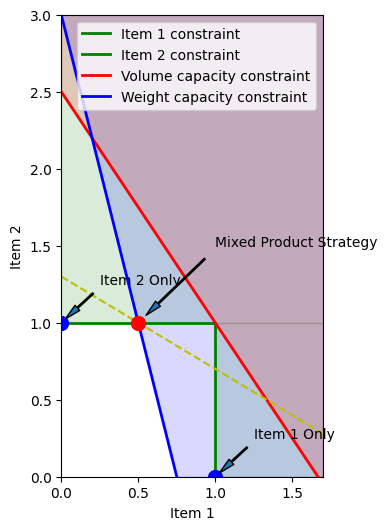

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_aspect('equal')
ax.axis([0, 1.7, 0, 3])
ax.set_xlabel('Item 1')
ax.set_ylabel('Item 2')

# Item 1 constraint
x = np.array([0, 2])
ax.plot([1, 1], [0, 1], 'g', lw=2)

# Item 2 constraint
x = np.array([0, 2])
ax.plot([0, 1], [1, 1], 'g', lw=2)

# Volume capacity constraint 60x + 40y = 100
ax.plot(x, 2.5 - 1.5*x, 'r', lw=2)

# Weight capacity constraint 40x + 10y = 30
ax.plot(x, 3 - 4*x, 'b', lw=2)

optimum = (0.5, 1)

# The constant p for the line equation 3x + 5y = p is derived from the red point's coordinates
p = 3 * optimum[0] + 5 * optimum[1]

# Plot the line that passes through the red point
x_vals = np.array(ax.get_xlim())
y_vals = (p - 3 * x_vals) / 5
ax.plot(x_vals, y_vals, 'y--')

ax.legend(['Item 1 constraint', 'Item 2 constraint', 'Volume capacity constraint', 'Weight capacity constraint'])
ax.fill_between([0, 1, 3], [1, 1, 1], [3, 3, 3], color='g', alpha=0.15)
ax.fill_between([1, 1.7], [0, 0], [1, 1], color='g', alpha=0.15)
ax.fill_between([0, 0.75, 1.7], [3, 0, 0], [3, 3, 3], color='b', alpha=0.15)
ax.fill_between([0, 5/3, 1.7], [2.5, 0, 0], [3, 3, 3], color='r', alpha=0.15)

arrowprops = dict(shrink=.1, width=1, headwidth=5)

# Optimum
ax.plot(0.5, 1, 'r.', ms=20)
ax.annotate('Mixed Product Strategy', xy=(0.5, 1), xytext=(1, 1.5), arrowprops=arrowprops)

ax.plot(0, 1, 'b.', ms=20)
ax.annotate('Item 2 Only', xy=(0, 1), xytext=(0.25, 1.25), arrowprops=arrowprops)

ax.plot(1, 0, 'b.', ms=20)
ax.annotate('Item 1 Only', xy=(1, 0), xytext=(1.25, 0.25), arrowprops=arrowprops)


plt.show()

Currently, the solution is (0.5,1). As we increase the ratio of the value for item 1 and the value for item 2 until 4 (currently it's 3/5 = 0.6), the solution will change to (0.75, 0)

### d. Assuming there is exactly one optimal solution, what is the maximum number of goods that the thief would take fractionally? Concisely explain why you know this to be true.

Assuming there is a exactly one optimal solution, the maximum number of goods that the thief would take fractionally is 2. This is because, in order to satisfy all the constraints and get a unique optimal solution in a LP problem, at least the equal number of constraints need to match the variables. In the knapsack problem, in addition to capacity limitations, the amount of each item taken is also limited by its availability, that's x ∈ [0,1].  

At least N inequalities must be satisfied (turned into equations). After adding the volume constraint, it's possible that the volume and weight capacity constraints are both tight simultaneously. Other N-2 constraints should be about the x ∈ [0,1]. Since the constraints xi ≤ 1 and xi ≥0 for each item cannot be strictly met at the same time (i.e., cannot be equalized at the same time), at most 2 items can be selected fractionally. Such a layout guarantees uniqueness of understanding and satisfies the needs of all constraints. Therefore, in the unique optimal solution, the thief can only take at most 2 item in fractional quantities.

### (e). Assume now that the thief has decided to enlist some friends, so that there are now k thieves with identical knapsacks, each limited to taking volume up to U, and weight up to W. The thieves wish to maximize the aggregate value gathered by the entire set of thieves. Again assuming there is exactly one optimal solution, what is the maximum number of goods that will be taken fractionally by our set of thieves in aggregate (i.e. after you add up the totals taken by all thieves)?

U: knapsack volume capacity  
W: knapsack weight capacity  
N: Num of goods in the warehouse  
k: Num of thieves  
u<sub>i</sub>: Total volume of the i<sup>th</sup> good  
w<sub>i</sub>: Total weight of the i<sup>th</sup> good  
v<sub>i</sub>: The value of the i<sup>th</sup> good  

**Decision variable**:  
y<sub>i</sub>: The fraction of the i<sup>th</sup> good taken by all thieves  


Objective function (maximize):
$$
\sum_{i} v_i y_i,
$$  
Restrictions 1: y<sub>i</sub> ≤ 1 for i = 1,2,...,N  
Restrictions 2:
$$
\sum_{i} w_i x_i ≤ kW
$$  
Restrictions 3:
$$
\sum_{i} u_i x_i ≤ kU
$$

Since every thief has the same restriction, and we assume an unique optimal solution, the number of items taken by the fraction in the overall optimal solution can only be two at most. This is because each thief will follow the same optimal strategy when solving their own backpack problem independently, that is, they will each independently get the same result. If, for the problem of a single backpack, at most two items are taken in fractional form (in order to achieve the boundary condition), then even if we have multiple thieves, each thief's solution will be a copy of the same optimal solution.  
From another perspective, we can view the k thieves as a whole. We just have to think about what is the maximum value we can get for the whole under the constraints. Their own internal distribution, who takes a little more or a little less, does not affect the overall outcome.  

## 3. Solving Inventory Optimization as a Network Flow

### 1. Model the problem as a min-cost flow to find the most profitable inventory planning up to time T.

#### Define variables:
*   $x_i$: Number of items manufactured on day i
*   $y_i$: Number of items sold on day i
*   $z_i$: Number of items held in inventory on day i
*   $w_i$: Number of items backordered from day i+1 to day i

#### Objective Function:

$ \text{Minimize} \sum\limits_{i=1}^T (c_i x_i) + \sum\limits_{i=1}^T(h z_i) + \sum\limits_{i=1}^T(b w_i) $


#### Subjected to:

$ y_i + w_i = d_i $

$ (x_i + z_{i-1}) - (y_i + w_i) = z_i $

$ x_i,  y_i,  z_i, w_i \ge 0 $



### 2. Using Pyomo, find the optimal planning when p=8, h=1, and b=2

In [ ]:
# Define the model
model = ConcreteModel()

# Parameters
model.T = 10  # Number of days
model.p = 8   # Selling price
model.h = 1   # Holding cost
model.b = 2   # Backlog cost
model.d = {1: 4, 2: 5, 3: 3, 4: 6, 5: 8, 6: 2, 7: 0, 8: 6, 9: 4, 10: 3}  # Demands
model.c = {1: 1, 2: 2, 3: 3, 4: 6, 5: 8, 6: 2, 7: 1, 8: 2, 9: 5, 10: 3}  # Manufacturing costs

# Decision variables
model.x = Var(range(1, model.T+1), domain=NonNegativeReals)  # Production
model.y = Var(range(1, model.T+1), domain=NonNegativeReals)  # Sales
model.z = Var(range(1, model.T+1), domain=NonNegativeReals)  # Inventory
model.w = Var(range(1, model.T+1), domain=NonNegativeReals)  # Backlogs

# Objective function
model.cost = Objective(expr=sum(model.c[t] * model.x[t] for t in range(1, model.T+1)) +
                       sum(model.h * model.z[t] for t in range(1, model.T+1)) +
                       sum(model.b * model.w[t] for t in range(1, model.T+1)),
                       sense=minimize)

# Constraints
def demand_satisfaction(model, t):
    return model.y[t] + sum(model.w[t] for t in range(1,model.T+1)) == model.d[t]
model.demand_satisfaction = Constraint(range(1, model.T+1), rule=demand_satisfaction)


def inventory_balance(model, t):
    if t == 1:
        return model.z[t] == (model.x[t]) - (model.y[t] + model.w[t])
    else:
        return model.z[t] == (model.x[t] + model.z[t-1]) - (model.y[t] + model.w[t])
model.inventory_balance = Constraint(range(1, model.T+1), rule=inventory_balance)


# Solve the model
solver = SolverFactory('cbc')
solver.solve(model)

# Print the solution
print(f"Total Cost: {model.cost()}")
for t in range(1, model.T+1):
    print(f"Day {t}: Production = {model.x[t]()}, Sales = {model.y[t]()}, Inventory = {model.z[t]()}, Backlogs = {model.w[t]()}")

Total Cost: 124.0
Day 1: Production = 9.0, Sales = 4.0, Inventory = 5.0, Backlogs = 0.0
Day 2: Production = 0.0, Sales = 5.0, Inventory = 0.0, Backlogs = 0.0
Day 3: Production = 17.0, Sales = 3.0, Inventory = 14.0, Backlogs = 0.0
Day 4: Production = 0.0, Sales = 6.0, Inventory = 8.0, Backlogs = 0.0
Day 5: Production = 0.0, Sales = 8.0, Inventory = 0.0, Backlogs = 0.0
Day 6: Production = 2.0, Sales = 2.0, Inventory = 0.0, Backlogs = 0.0
Day 7: Production = 10.0, Sales = 0.0, Inventory = 10.0, Backlogs = 0.0
Day 8: Production = 0.0, Sales = 6.0, Inventory = 4.0, Backlogs = 0.0
Day 9: Production = 0.0, Sales = 4.0, Inventory = 0.0, Backlogs = 0.0
Day 10: Production = 3.0, Sales = 3.0, Inventory = 0.0, Backlogs = 0.0


When p=8, h=1, and b=2, the minimum total cost is $124

## 4. Task Allocation

### 1. Given the context information, $A$, $B$, $c$, and $d$, reduce this problem to a minimum cut problem in order to find a reassignment of tasks into groups $A$ and $B$ such that the cost $qd + pc$ is minimized.

#### Define Variables:
*   $q_{ij}$: binary variable indicating whether the edge ($v_i$, $v_j$) is part of the cut or not.
*   $y_i$: binary variable indicating whether the group assignment of task $v_i$ has been changed or not.

#### Objective Function:
$\text{Minimize} \sum_{i,j} d_{ij} q_{ij} + \sum_{i} c_i y_i$

#### Subjected to:
$ q_{ij} = max(p_i - p_j, 0)$, ∀(i, j) ∈ E

$ y_i ≥ p_i - p_i^0$, ∀i ∈ V

$ y_i ≥ p_i^0 - p_i$, ∀i ∈ V

$ p_d = p_s = 1$

$ p_i ∈ {0, 1}$, ∀i ∈ V

$ y_i ∈ {0, 1}$, ∀i ∈ V

### 2. Using Pyomo solve the following real instance.
In your solution make sure to include the new assignments of tasks into groups A and B.

There are 11 taks in a factory who are labeled with numbers 1, 2, . . ., 11. The following table shows the relations. Let c = 15, d = 10, A = {1, 2, 3, 4, 5}, and B = {6, 7, 8, 9, 10, 11}.

Tasks with similar context information:
[(1,5), (1,10), (2,7), (2,8), (2,9), (2,10), (3,10), (4,10) , (5,6), (5,11), (7,9)]

In [ ]:
# Create a concrete model
model = ConcreteModel()

# Define sets
N = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # Set of tasks
A = [1, 2, 3, 4, 5]  # Initially assigned to group A
B = [6, 7, 8, 9, 10, 11]  # Initially assigned to group B
Relations = [(1, 5), (1, 10), (2, 7), (2, 8), (2, 9), (2, 10), (3, 10), (4, 10), (5, 6), (5, 11), (7, 9)]  # Pairs of tasks that share context

# Define parameters
c = 15  # Cost of changing group assignment
d = 10  # Information transfer cost

# Define binary variables
model.p = Var(N, domain=Binary)  # p[i] = 1 if task i is assigned to B, 0 if assigned to A
model.q = Var(Relations, domain=Binary)  # q[i,j] = 1 if tasks i and j are assigned to different machines
model.y = Var(N, domain=Binary)  # y[i] = 1 if task i is reassigned from its initial assignment

# Define the objective function
model.obj = Objective(expr=sum(d * model.q[i, j] for i, j in Relations) + sum(c * model.y[i] for i in N), sense=minimize)

# Define constraints
def q_constraint(model, i, j):
    return model.q[i, j] >= model.p[i] - model.p[j]
model.q_con = Constraint(Relations, rule=q_constraint)

def q_constraint2(model, i, j):
    return model.q[i, j] >= model.p[j] - model.p[i]
model.q_con2 = Constraint(Relations, rule=q_constraint2)

def change_constraint_A(model, i):
    if i in A:
        return model.y[i] >= model.p[i]
    else:
        return Constraint.Skip
model.change_con_A = Constraint(N, rule=change_constraint_A)

def change_constraint_B(model, i):
    if i in B:
        return model.y[i] >= 1 - model.p[i]
    else:
        return Constraint.Skip
model.change_con_B = Constraint(N, rule=change_constraint_B)

# Solve the problem
solver = SolverFactory('cbc')
solver.solve(model)

# Print the solution
print("Objective value:", model.obj())

# Get the new assignments
new_A = [i for i in N if model.p[i].value == 0]
new_B = [i for i in N if model.p[i].value == 1]
print("New group A:", new_A)
print("New group B:", new_B)

Objective value: 60.0
New group A: [1, 3, 4, 5, 10]
New group B: [2, 6, 7, 8, 9, 11]


This solution reassigns tasks 2 and 10, which makes the change cost 30. The transfer cost happened 3 times within the 11 task, which also costs 30. So the total cost of this solution is 60.

## 5. Multi-commodity flow Network 10

Define variables
* $G = (V, E)$ as the graph where $V$ is the set of nodes and $E$ the set of edges
* $K$ as the set of commodities
* $u_{ij}$ as the capacity of edge $(i,j) \in E$
* $c_{ij}$ as the cost per unit flow of edge $(i,j) \in E$
* $d_{ik}$ as the demand of commodity $k$ at node $i$
* $s_{ik}$ as the supply of commodity $k$ at node $i$
* $x_{ijk}$ as the flow of commodity $k$ along edge $(i,j)$






#### Objective function
Min transportation cost
$$
\text{Minimize} \quad \sum_{(i,j) \in E} \sum_{k \in K} c_{ij} x_{ijk}
$$

#### Constraints
$$
 \text{sources, sinks} : \quad \sum_{j: (i, j) \in E} x_{ijk} - \sum_{j: (j, i) \in E} x_{jik} = s_{ik} - d_{ik}
$$

$$
\quad \sum_{k \in K} x_{ijk} \leq u_{ij}, \forall (i,j) \in E
$$

$$
 \quad x_{ijk} \geq 0, \forall (i,j) \in E, \forall k \in K :
$$




* Nodes: ${1, 2, 3}$
* Edges: $(1, 2), (2, 3), (1, 3)$
* Commodities: ${A, B, C}$
* Capacities: $u_{12} = u_{23} = u_{13} = 1$
* Costs: Assume $c_{ij} = 1$ for simplicity
*Demands and Supplies:
$s_{1A} = s_{1B} = s_{1C} = 1$, $d_{3A} = d_{3B} = d_{3C} = 1$
* All other $d_{ik} = s_{ik} = 0$

In [ ]:
!apt-get install -y -qq glpk-utils

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 121797 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

In [ ]:
from pyomo.environ import *

# Initialize the model
model = ConcreteModel()

# Define sets for nodes, edges, and commodities
nodes = ['A', 'B', 'C']
edges = [('A', 'B'), ('B', 'C'), ('A', 'C')]
commodities = ['1', '2', '3']

# Define parameters: capacity and demand for each node and commodity
capacity = {('A', 'B'): 1, ('B', 'C'): 1, ('A', 'C'): 1}
demand = {('C', '1'): 1, ('C', '2'): 1, ('C', '3'): 1}

# Variables: flow of each commodity on each edge
model.flow = Var(edges, commodities, within=NonNegativeReals)

# Objective: Minimize cost (assuming a cost of 1 for simplicity)
model.cost = Objective(
    expr=sum(model.flow[e, k] for e in edges for k in commodities),
    sense=minimize
)

# Constraints

# Capacity constraints for each edge
def capacity_rule(model, i, j):
    return sum(model.flow[i, j, k] for k in commodities) <= capacity[i, j]

model.capacity_constraints = Constraint(edges, rule=capacity_rule)

# Flow conservation for each commodity and node
def flow_conservation_rule(model, n, k):
    if n == 'C':
        # Demand nodes
        return sum(model.flow[i, n, k] for i, j in edges if (i, n) in edges) == demand[n, k]
    elif n != 'A':
        # Intermediate nodes
        return (sum(model.flow[i, n, k] for i, j in edges if (i, n) in edges) -
                sum(model.flow[n, j, k] for i, j in edges if (n, j) in edges)) == 0
    else:
        # Supply nodes (not explicitly modeled in this example)
        return Constraint.Skip

model.flow_conservation = Constraint(nodes, commodities, rule=flow_conservation_rule)

# Solve the model
from pyomo.environ import SolverFactory

solver = SolverFactory('cbc')
result = solver.solve(model, tee=True)

# Output results
print(f"Status: {result.solver.status}")
for e in edges:
    for k in commodities:
        print(f"Flow of commodity {k} on edge {e}: {model.flow[e, k].value}")


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpoox_zkf0.pyomo.lp -stat=1 -solve -solu /tmp/tmpoox_zkf0.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-9) rows, 0 (-9) columns and 0 (-21) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 22010 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-9) rows, 0 (-9) columns and 0 (-21) elements
Empty pr

## 6. Shortest path problem

### 1. the shortest path from A to B.

### Variables
* $x_{ij}$ in \{0, 1\} for each edge (i,j), which takes the value 1 if the edge is used in the path from A to B and 0 otherwise

### Obective Function
Min total cost path from A to B
$$
 \text{Minimize} \quad \sum_{(i,j) \in E} c_{ij} x_{ij}
$$

### Constraints
* $ \sum_{(A,j) \in E} x_{Aj} = 1 $
* $\sum_{(i,B) \in E} x_{iB} = 1 $
* $ \forall i \in V \setminus \{A, B\} : \sum_{(i,j) \in E} x_{ij} - \sum_{(j,i) \in E} x_{ji} = 0 $
* $ x_{ij} \in \{0, 1\} \quad \forall (i,j) \in E$





In [ ]:
from pyomo.environ import *

# Define the model
model = ConcreteModel()

# Nodes in the graph
nodes = ['A', 'C', 'D', 'S', 'F', 'G', 'T', 'B']

# Edges and their corresponding costs
edges = {('A', 'C'): 7000, ('A', 'D'): 4000, ('A', 'S'): 1000,
         ('C', 'D'): 2000, ('C', 'T'): 4000, ('D', 'T'): 2000,
         ('D', 'F'): 2000, ('S', 'D'): 1000, ('S', 'F'): 3000,
         ('S', 'G'): 5000, ('F', 'B'): 2000, ('F', 'T'): 6000,
         ('G', 'T'): 0, ('T', 'B'): 1000, ('G', 'B'): 2000}

# Define the variables
model.x = Var(edges.keys(), within=Binary)

# Objective: Minimize the cost of the path
model.cost = Objective(expr=sum(edges[e]*model.x[e] for e in edges), sense=minimize)

# Constraints
def source_rule(model, i):
    if i == 'A':
        return sum(model.x[('A', j)] for j in nodes if ('A', j) in edges) == 1
    else:
        return Constraint.Skip
model.source = Constraint(nodes, rule=source_rule)

def sink_rule(model, i):
    if i == 'B':
        return sum(model.x[(j, 'B')] for j in nodes if (j, 'B') in edges) == 1
    else:
        return Constraint.Skip
model.sink = Constraint(nodes, rule=sink_rule)

def conservation_rule(model, i):
    if i not in ['A', 'B']:
        return (sum(model.x[(i, j)] for j in nodes if (i, j) in edges) -
                sum(model.x[(j, i)] for j in nodes if (j, i) in edges)) == 0
    else:
        return Constraint.Skip
model.conservation = Constraint(nodes, rule=conservation_rule)

# Solve the model
solver = SolverFactory('cbc')
result = solver.solve(model, tee=True)

# Output results
print(f"Status: {result.solver.status}")
for e in model.x:
    if model.x[e].value == 1:
        print(f"Use edge {e} with cost {edges[e]}")


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpk172y575.pyomo.lp -stat=1 -solve -solu /tmp/tmpk172y575.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 4 (-4) rows, 11 (-4) columns and 22 (-8) elements
Statistics for presolved model
Original problem has 15 integers (15 of which binary)
Presolved problem has 11 integers (11 of which binary)
==== 0 zero objective 7 different
2 variables have objective of 1000
2 variables have objective of 2000
2 variables have objective of 3000
1 variables have objective of 5000
2 variables have objective of 6000
1 variables have objective of 8000
1 variables have objective of 10000
==== absolute objective values 7 different
2 variables have objective of 1000
2 variables have objective of 2000
2 variables have objective of 3000
1 variables have objective of 5000
2 variables have objective of 6000
1 variables have obje

### 2. the most reliable path from A to B. Assume that different pipelines fail independently of each other.



### Define variables
* $x_{ij} \in \{0, 1\}$ for each (i, j) which takes the value 1 if the edge is used in the most reliable path from A to B and 0 otherwise.

### Objective function
$$ \text{Maximize overall reliability} \quad \sum_{(i,j) \in E} x_{ij} \log(R_{ij}) $$

### Constraints
* $\sum_{(A,j) \in E} x_{Aj} = 1 $
* $ \forall i \in V \setminus \{A, B\} : \sum_{(i,j) \in E} x_{ij} - \sum_{(j,i) \in E} x_{ji} = 0 $
* $ x_{ij} \in \{0, 1\} \quad \forall (i,j) \in E $




In [ ]:
from pyomo.environ import *
import math

# Initialize the model
model = ConcreteModel()

# Define sets for nodes and edges
nodes = {'A', 'B', 'C', 'D', 'S', 'F', 'G', 'T'}
edges = {('A', 'C'), ('A', 'D'), ('A', 'S'), ('C', 'D'), ('C', 'T'),
         ('D', 'T'), ('D', 'F'), ('S', 'D'), ('S', 'F'), ('S', 'G'),
         ('F', 'B'), ('F', 'T'), ('G', 'T'), ('T', 'B'), ('G', 'B')}

# Define parameters for failure probability of each edge
failure_prob = {('A', 'C'): 0.4, ('A', 'D'): 0.9, ('A', 'S'): 0.1,
                ('C', 'D'): 0.2, ('C', 'T'): 0.0, ('D', 'T'): 0.5,
                ('D', 'F'): 0.1, ('S', 'D'): 0.3, ('S', 'F'): 0.4,
                ('S', 'G'): 0.2, ('F', 'B'): 0.2, ('F', 'T'): 0.2,
                ('G', 'T'): 1.0, ('T', 'B'): 0.6, ('G', 'B'): 0.8}

# Calculate reliability as 1 - failure probability and handle zero reliability
reliability = {e: max(1 - failure_prob[e], 1e-10) for e in edges}  # Use a small positive number instead of 0

# Decision variable: x_ij = 1 if edge (i, j) is used in the path
model.x = Var(edges, within=Binary)

# Objective: Maximize the sum of logarithms of edge reliabilities, excluding edges with zero reliability
def objective_rule(m):
    return sum(model.x[e] * math.log(reliability[e]) for e in edges if reliability[e] > 0)
model.objective = Objective(rule=objective_rule, sense=maximize)

# Constraint: Ensure that exactly one edge leaves node A
def source_rule(m):
    return sum(model.x[('A', j)] for j in nodes if ('A', j) in edges) == 1
model.source = Constraint(rule=source_rule)

# Constraint: Ensure that exactly one edge enters node B
def sink_rule(m):
    return sum(model.x[(i, 'B')] for i in nodes if (i, 'B') in edges) == 1
model.sink = Constraint(rule=sink_rule)

# Flow conservation constraints:
# The sum of inflows should be equal to the sum of outflows for all nodes except A and B
def conservation_rule(m, n):
    if n not in ['A', 'B']:
        return (sum(model.x[(i, n)] for i in nodes if (i, n) in edges) -
                sum(model.x[(n, j)] for j in nodes if (n, j) in edges)) == 0
    else:
        return Constraint.Skip
model.conservation = Constraint(nodes, rule=conservation_rule)

# Solve the model using CBC solver
solver = SolverFactory('cbc')
result = solver.solve(model, tee=True)

# Output the results
print(f"Status: {result.solver.status}")
for e in edges:
    if model.x[e].value == 1:
        print(f"Use edge {e} with reliability {reliability[e]}")

print("Objective (Maximized Log-Reliability):", model.objective.expr())


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpb10vgj6o.pyomo.lp -stat=1 -solve -solu /tmp/tmpb10vgj6o.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
Presolve 4 (-4) rows, 11 (-4) columns and 22 (-8) elements
Statistics for presolved model
Original problem has 15 integers (15 of which binary)
Presolved problem has 11 integers (11 of which binary)
==== 0 zero objective 11 different
1 variables have objective of -23.249
1 variables have objective of -2.19722
1 variables have objective of -0.916291
1 variables have objective of -0.693147
1 variables have objective of -0.628609
1 variables have objective of -0.510826
1 variables have objective of -0.405465
1 variables have objective of -0.356675
1 variables have objective of 